Generating Test Data...
Threshold: 0.0542
Exporting results to Excel...
Saved 'inference_results_with_flags.xlsx'.


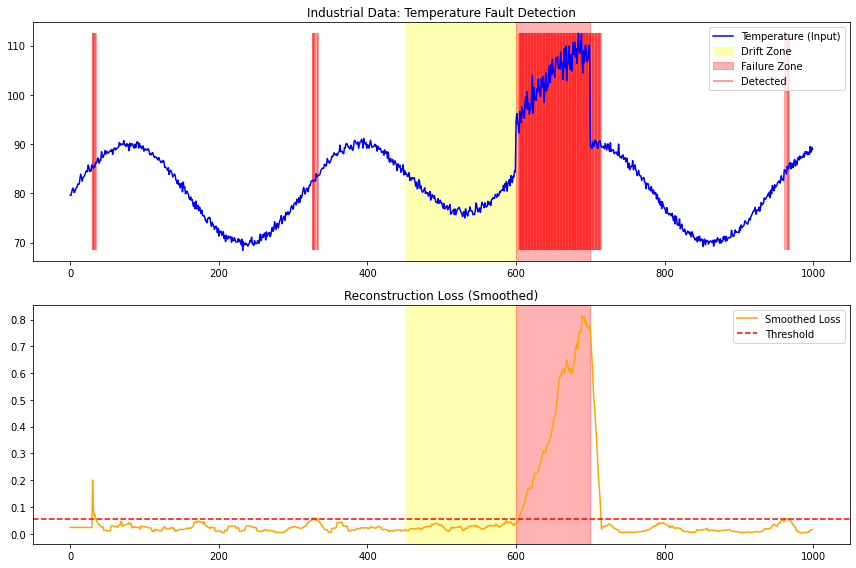

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib # To load scaler
import seaborn as sns

from lstm_vae import LSTM_VAE
from data_utils import generate_industrial_data, create_sliding_windows

def detect_anomalies():
    SEQ_LEN = 30
    NUM_FEATURES = 3
    HIDDEN_DIM = 64
    LATENT_DIM = 16
    DEVICE = torch.device('cpu') 

    # --- 1. Generate Test Data & Inject Faults ---
    print("Generating Test Data...")
    df = generate_industrial_data(length=1000)
    data = df.values # Convert to numpy

    # --- INJECT FAULTS INTO TEMPERATURE (Feature 0) ---
    # A. PRECURSOR (Drift): Index 450 to 600
    # Simulating "Overheating" start
    drift_start, drift_end = 450, 600
    drift_amount = np.linspace(0, 10, drift_end - drift_start) # Drift up by 10 degrees
    data[drift_start:drift_end, 0] += drift_amount

    # B. FAILURE (Crash): Index 600 to 700
    fail_start, fail_end = 600, 700
    data[fail_start:fail_end, 0] += 20.0 # Huge spike
    data[fail_start:fail_end, :] += np.random.normal(0, 2.0, (fail_end - fail_start, NUM_FEATURES))

    # --- 2. Scale Data ---
    scaler = joblib.load('scaler.pkl')
    data_scaled = scaler.transform(data)

    # --- 3. Run Inference ---
    windows = create_sliding_windows(data_scaled, SEQ_LEN)
    input_tensor = torch.tensor(windows).float().to(DEVICE)

    model = LSTM_VAE(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, SEQ_LEN, DEVICE).to(DEVICE)
    model.load_state_dict(torch.load('lstm_vae_model_industrial.pth', map_location=DEVICE))
    model.eval()

    criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        recon, _, _ = model(input_tensor)
        loss_matrix = criterion(recon, input_tensor)
        # Use Last Step Error
        raw_losses = loss_matrix[:, -1, 0].numpy()

    # --- 4. SMOOTHING (The key to early detection) ---
    # Rolling Mean of 15 steps
    smoothed_losses = pd.Series(raw_losses).rolling(window=15, min_periods=1).mean().values

    # --- 5. Threshold Calculation ---
    # Calibrate on first 400 points (assumed healthy)
    calib_data = smoothed_losses[:400]
    mu = np.mean(calib_data)
    sigma = np.std(calib_data)
    
    threshold = mu + (2 * sigma)
    print(f"Threshold: {threshold:.4f}")

    # Pad losses to match original data length
    padded_losses = np.pad(smoothed_losses, (SEQ_LEN, 0), mode='constant', constant_values=mu)

    # --- 6. Create Anomaly Flags ---
    # 0 = Normal, 1 = Anomaly
    anomaly_flags = (padded_losses > threshold).astype(int)

    # --- 7. Export to Excel ---
    print("Exporting results to Excel...")
    results_df = pd.DataFrame(data, columns=['Temperature', 'Pressure', 'Torque'])
    results_df['Reconstruction_Loss'] = padded_losses
    results_df['Threshold'] = threshold
    results_df['Anomaly_Flag'] = anomaly_flags
    
    # Add a column explaining the Ground Truth for comparison
    results_df['Status_Ground_Truth'] = 'Normal'
    results_df.loc[drift_start:drift_end, 'Status_Ground_Truth'] = 'Drift (Precursor)'
    results_df.loc[fail_start:fail_end, 'Status_Ground_Truth'] = 'Failure'

    results_df.to_excel("inference_results_with_flags.xlsx", index=False)
    print("Saved 'inference_results_with_flags.xlsx'.")

    # --- 8. Visualization ---
    plt.figure(figsize=(12, 8))
    
    # Plot Temperature
    plt.subplot(2, 1, 1)
    plt.plot(data[:, 0], label='Temperature (Input)', color='blue')
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.3, label='Drift Zone')
    plt.axvspan(fail_start, fail_end, color='red', alpha=0.3, label='Failure Zone')
    
    # Plot Red Lines where Flag == 1
    anom_indices = np.where(anomaly_flags == 1)[0]
    if len(anom_indices) > 0:
         plt.vlines(anom_indices, ymin=min(data[:,0]), ymax=max(data[:,0]), 
                   colors='red', alpha=0.5, label='Detected')
    
    plt.title('Industrial Data: Temperature Fault Detection')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 1, 2)
    plt.plot(padded_losses, label='Smoothed Loss', color='orange')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.3)
    plt.axvspan(fail_start, fail_end, color='red', alpha=0.3)
    plt.title('Reconstruction Loss (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    detect_anomalies()